In [1]:
import os, argparse, shutil
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
import subprocess
from itertools import groupby, count
from collections import deque
from io import StringIO

In [2]:
# translate for building complement of a DNA sequence
compl = str.maketrans('ATGCNatgcn', 'TACGNatgcn')

In [3]:
class ArgHelpFormatter(argparse.HelpFormatter):
    '''
    Formatter adding default values to help texts.
    '''
    def __init__(self, prog):
        super().__init__(prog)

    ## https://stackoverflow.com/questions/3853722
    #def _split_lines(self, text, width):
    #   if text.startswith('R|'):
    #       return text[2:].splitlines()  
    #   # this is the RawTextHelpFormatter._split_lines
    #   return argparse.HelpFormatter._split_lines(self, text, width)

    def _get_help_string(self, action):
        text = action.help
        if  action.default is not None and \
            action.default != argparse.SUPPRESS and \
            'default:' not in text.lower():
            text += ' (default: {})'.format(action.default)
        return text

In [84]:
def get_args(args=None):
    parser = argparse.ArgumentParser(description='Estimates read starts (transposase insertion sites) for ONT rapid libraries',
                                     formatter_class=ArgHelpFormatter, 
                                     add_help=False)

    main_group = parser.add_argument_group('Main Options')
    main_group.add_argument('reads',
                            nargs='+',
                            help='fastq files or path to directories containing fastq files (recursion depth 1)')
    main_group.add_argument('genome',
                            help='Fasta file containing the genomic sequences that is searched for insertion sites.')
    main_group.add_argument('adapter',
                            help='Transposon Y adapter sequence')
    main_group.add_argument('--prefix',
                            help="filename for readstarts in tap seperated value (.tsv) format",
                            default="readstarts")
    #main_group.add_argument('--verbose_out_file',
    #                        help="print detailed, human readable information about each read to this file")
    #main_group.add_argument('--verbose_col_width',
    #                        help="column width for verbose output",
    #                        type=int,
    #                        default=250)
    main_group.add_argument('--plot',
                            help='plot results of gaussian approximation',
                            action='store_true')
    main_group.add_argument('--circular',
                            action="store_true")
    main_group.add_argument('--strip',
                            help="number of bases stripped from alignments to cope with coincidently identical sequences",
                            type=int,
                            default=5)
    main_group.add_argument('--wordsize',
                            help='',
                            type=int,
                            default=8)
    main_group.add_argument('--max_dist',
                            help='''max distance between an adapter and a genome alignment to perform pairwise-alignment 
                                 in order to identify the exact transition point''',
                            type=int,
                            default=100)
    main_group.add_argument('--min_readlength',
                            help="min length of reads to be analyzed",
                            type=int,
                            default=500)
    main_group.add_argument('--processes',
                            type=int,
                            default=6)
    main_group.add_argument('--batchsize',
                            type=int,
                            default=8000)

    filter_group = parser.add_argument_group('Filter Options')
    filter_group.add_argument('--mean',
                              help='mean of per-base difference of actual sequence length from read length',
                              type=float)
    filter_group.add_argument('--std',
                              help='standard deviation of per-base difference of actual sequence length from read length',
                              type=float)
    filter_group.add_argument('--min_blen',
                              help="min produced alignment length (including errors)",
                              type=int,
                              default=20)
    filter_group.add_argument('--min_adapter_blen',
                              help="min produced alignment length (including errors)",
                              type=int,
                              default=50)
    filter_group.add_argument('--min_genome_blen',
                              help="min produced alignment length (including errors)",
                              type=int,
                              default=50)
    filter_group.add_argument('--f_window',
                              help="sequence window around the position of transition from "+\
                                   "the adapter sequence to the chromosome sequence",
                              type=int,
                              default=7)
    filter_group.add_argument('--f_max_w_err',
                              help="max amount of errors (insertions, deletions, mismatches) "+\
                                   "within the specified sequence window",
                              type=int,
                              default=3)
    filter_group.add_argument('--f_max_mm_strech',
                              help="max amount of deletions or insertions in the whole realignment",
                              type=int,
                              default=3)

    help_group = parser.add_argument_group('Help')
    help_group.add_argument('-h', '--help', 
                            action='help', 
                            default=argparse.SUPPRESS,
                            help='Show this help message and exit.')
    if args:
        return parser.parse_args(args)
    return parser.parse_args()

In [5]:
def run_minimap2(ref_fn, fq_fn, paf_fn):
    cmd ='minimap2 -x map-ont -c --eqx --secondary=no -t 4 {} {} >{} 2> /dev/null'.format(ref_fn, fq_fn, paf_fn)
    #print('Running:', cmd)
    return os.system(cmd)

In [6]:
def parse_paf(fn, cigar=False):
    usecols = list(range(12))
    names = ["qid", "qlen", "qst", "qen", "strand", "subj", 
             "slen", "sst", "sen", "mlen", "blen", "mapq"]
    dtype = {"qid": str, "qlen": np.int32, "qst": np.int32, 
             "qen": np.int32, "strand": str, "subj": str,
             "slen": np.int32, "sst": np.int32, "sen": np.int32, 
             "mlen": np.int32, "blen": np.int32, "mapq": np.int32}
    converters = {}
    if cigar:
        usecols.append(22)
        names.append('cg')
        converters['cg'] = lambda x: x.split(':')[-1]
    return pd.read_csv(fn, sep='\t', header=None,
                       usecols=usecols,
                       names=names,
                       dtype=dtype,
                       converters=converters)

In [7]:
def get_query_seq(df, sel):
    #probl_st_plus = sel_plus & (df[sel_plus].cg_ad.str.replace('D|I', 'X').str.rstrip('=').str.rsplit('X', n=1).str[-1].astype(int) < args.wordsize)
    #probl_en_minus = sel_minus & (df[sel_minus].cg_ad.str.split('=', n=1).str[0].astype(int) < args.wordsize)
    cg_ad = df.cg_ad.str.replace('D|I', 'X')
    cg_gn = df.cg_gn.str.replace('D|I', 'X')
    
    sel_ = sel & (df.trans_order == 1.) & (cg_ad.str.rstrip('=').str.rsplit('X', n=1).str[-1].astype(np.float32) >= args.wordsize) # & (df.strand_ad == '+')
    df.loc[sel_ , 
           'query_st'] = df[sel_].qen_ad
    sel_ = sel & (df.trans_order == 1.) & (cg_gn.str.split('=', n=1).str[0].astype(np.float32) >= args.wordsize) # & (df.strand_ad == '+')
    df.loc[sel_ , 
           'query_en'] = df[sel_].qst_gn
    
    sel_ = sel & (df.trans_order == -1.) & (cg_gn.str.rstrip('=').str.rsplit('X', n=1).str[-1].astype(np.float32) >= args.wordsize) # & (df.strand_ad == '+') 
    df.loc[sel_ , 
           'query_st'] = df[sel_].qen_gn
    sel_ = sel & (df.trans_order == -1.) & (cg_ad.str.split('=', n=1).str[0].astype(np.float32) >= args.wordsize) # & (df.strand_ad == '+')
    df.loc[sel_ , 
           'query_en'] = df[sel_].qst_ad
    
    #sel_ = sel & (df.strand_ad == '-') & (df.trans_order == 1.)
    #df.loc[sel_ & (cg_ad.str.rstrip('=').str.rsplit('X', n=1).str[-1].astype(int) >= args.wordsize), 
    #       'query_st'] = df[sel_].qen_ad
    #df.loc[sel_ & (cg_gn.str.split('=', n=1).str[0].astype(int) >= args.wordsize), 
    #       'query_en'] = df[sel_].qst_gn
    
    #sel_ = sel & (df.strand_ad == '-') & (df.trans_order == -1.)
    #df.loc[sel_ & (cg_gn.str.rstrip('=').str.rsplit('X', n=1).str[-1].astype(int) >= args.wordsize), 
    #       'query_st'] = df[sel_].qen_gn
    #df.loc[sel_ & (cg_ad.str.split('=', n=1).str[0].astype(int) >= args.wordsize), 
    #       'query_en'] = df[sel_].qst_ad
    
    df.loc[sel, 'query_st'] -= args.strip
    df.loc[sel, 'query_en'] += args.strip
    return df

In [8]:
def sequence_length_stats(df):
    dfs = []
    # add length of read seq that aligns as "qalen"
    dfs.append((df[df.subj.notnull()].qen - df[df.subj.notnull()].qst).to_frame(name='qalen'))
    # add length of genome seq that aligns as "salen"
    dfs.append((df[df.subj.notnull()].sen - df[df.subj.notnull()].sst).abs().to_frame(name='salen'))
    ## add match, mismatch, insertion and deletion counts
    #two_groups = '(?P<digit>[0-9]*)(?P<letter>[=XID])'
    #d = df[df.subj_gn.notnull()].cg_gn.str.extractall(two_groups)
    #d.loc[:, 'digit'] = d.digit.astype("float32")
    #for letter in ['=', 'X', 'I', 'D']:
    #    dfs.append(d.loc[d.letter == letter].groupby(level=0).agg('sum').rename(columns = {'digit':letter}))
    stats = pd.concat(dfs, axis=1).fillna(0.)
    data = (stats.salen - stats.qalen)/stats.qalen
    args.mean, args.std = norm.fit(data)
    if args.plot:
        fig, ax = plt.subplots(figsize=(8,6))
        ax.hist(data, bins=100, density=True)
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 200)
        y = norm.pdf(x, args.mean, args.std)
        ax.plot(x, y)
        plt.show()

In [85]:
args = get_args(['barcode16.fastq', 'MIT52.fa', 'pUC19_ISCg1.fa', '--prefix', 'barcode16', '--wordsize', '6', '--plot'])

In [10]:
fq_files = []
for entry in args.reads:
    if os.path.isfile(entry) and (entry.endswith(".fastq") or entry.endswith(".fq")):
        fq_files.append(entry)
    else:
        fq_files.extend([os.path.join(entry, f) for f in os.listdir(entry) if os.path.isfile(os.path.join(entry, f)) \
            and (f.endswith(".fastq") or f.endswith(".fq"))])

In [11]:
adapter = {}
print(" - reading adapter sequence ...")
for record in SeqIO.parse(args.adapter, "fasta"):
    adapter[str(record.id)] = str(record.seq)
adapter = pd.DataFrame.from_dict(adapter, orient='index', columns=['seq'], dtype='string')
print('{:>11} adapter sequence(s) in fasta file'.format(len(adapter)))

print(" - reading genome fasta ...")
genome = {}
for record in SeqIO.parse(args.genome, "fasta"):
    genome[str(record.id)] = str(record.seq)
genome = pd.DataFrame.from_dict(genome, orient='index', columns=['seq'], dtype='string')
print('{:>11} genomic sequence(s) in fasta file'.format(len(genome)))

print(" - reading fastq files ...")
reads = {}
#reads = pd.DataFrame([], {'seq':Seq})
for fqFile in fq_files:
    for record in SeqIO.parse(fqFile, "fastq"):
        reads[str(record.id)] = str(record.seq)
reads = pd.DataFrame.from_dict(reads, orient='index', columns=['seq'], dtype='string')
print("{:>11} reads in dataset\n".format(len(reads)))

 - reading adapter sequence ...
          1 adapter sequence(s) in fasta file
 - reading genome fasta ...
          1 genomic sequence(s) in fasta file
 - reading fastq files ...
     272410 reads in dataset



In [12]:
#df = pd.DataFrame([(rid, len(seq)) for rid,seq in reads.items()], columns=['rid', 'rlen']).set_index('rid', drop=False)

In [13]:
tmp_dir = '{}_tmp'.format(args.prefix)
if os.path.exists(tmp_dir):
    shutil.rmtree(tmp_dir)
os.makedirs(tmp_dir)

In [14]:
print(" - performing reads to adapter reference mapping ...")
fq_fn = " ".join(fq_files)
ref_fn = args.adapter
paf_fn = os.path.join(tmp_dir, "adapter_alignment.paf")
exit_code = run_minimap2(ref_fn, fq_fn, paf_fn)
if exit_code:
    print('ERROR: adapter reference mapping failed with exit code', exit_code)
    exit(1)
ad_algn_df = parse_paf(paf_fn, cigar=True)#.set_index('qid')
print("{:>11} {:>7} primary alignments against adapter sequence(s)".format(len(ad_algn_df), ""))
c = sum(ad_algn_df.strand == '+')
print("{:>11} {:>5.1f} % against (+) strand".format(c, c/len(ad_algn_df)*100.))
c = sum(ad_algn_df.strand == '-')
print("{:>11} {:>5.1f} % against (-) strand".format(c, c/len(ad_algn_df)*100.))
#df = pd.merge(df, algn_df, how='outer', left_index=True, right_index=True, sort=False, suffixes=('_x', '_y'))

 - performing reads to adapter reference mapping ...
     175673         primary alignments against adapter sequence(s)
      58740  33.4 % against (+) strand
     116933  66.6 % against (-) strand


In [15]:
print(" - performing reads to genome reference mapping ...")
ref_fn = args.genome
paf_fn = os.path.join(tmp_dir, "genome_alignment.paf")
exit_code = run_minimap2(ref_fn, fq_fn, paf_fn)
if exit_code:
    print('ERROR: adapter reference mapping failed with exit code', exit_code)
    exit(1)
gn_algn_df = parse_paf(paf_fn, cigar=True)#.set_index('qid')
print("{:>11} {:>7} primary alignments against genomic sequence(s)".format(len(gn_algn_df), ""))
c = sum(gn_algn_df.strand == '+')
print("{:>11} {:>5.1f} % against (+) strand".format(c, c/len(gn_algn_df)*100.))
c = sum(gn_algn_df.strand == '-')
print("{:>11} {:>5.1f} % against (-) strand".format(c, c/len(gn_algn_df)*100.))
#df = pd.merge(df, algn_df, how='outer', left_index=True, right_index=True, sort=False, suffixes=('_ad', '_gn'))

 - performing reads to genome reference mapping ...
     143593         primary alignments against genomic sequence(s)
      95609  66.6 % against (+) strand
      47984  33.4 % against (-) strand


 - determining statistics about per-base difference ([align. subject len] - [align. query len]) / [align. query len] al from genome alignments


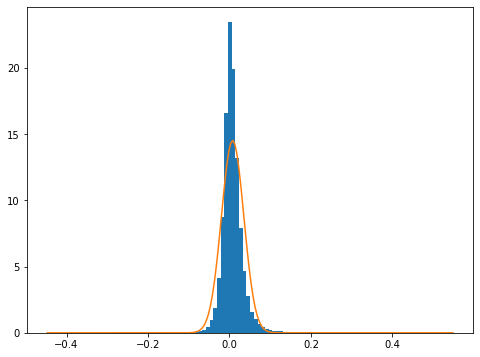

     0.0079 mean of per-base difference in sequence length
     0.0275 std dev of per-base difference in sequence length


In [16]:
if not (args.mean and args.std):
    print(" - determining statistics about per-base difference ([align. subject len] - [align. query len]) / [align. query len] al from genome alignments")
    sequence_length_stats(gn_algn_df)
    print("{:>11.4f} mean of per-base difference in sequence length".format(args.mean))
    print("{:>11.4f} std dev of per-base difference in sequence length".format(args.std))

In [33]:
print(" - joining alignment data and filtering for adjacent adapter-genome alignments")
# determine order of alignments of each read with respect to each adapter-subject pair
d = pd.concat([ad_algn_df, gn_algn_df], keys=['ad', 'gn'])
for ad_id in adapter.index:
    for gn_id in genome.index:
        comb = [ad_id, gn_id]
        o = d.loc[(d.subj.isin(comb))].sort_values(by=["qid", "qst"], ascending=True)
        d.loc[o.index, ":".join(comb)] = np.arange(len(o))

 - joining alignment data and filtering for adjacent adapter-genome alignments


In [99]:
d_ad = pd.merge(pd.DataFrame(reads.index, columns=['rid']).set_index('rid', drop=False), d.loc[d.index.droplevel(1) == 'ad'].set_index('qid', drop=False),
                how='outer', left_index=True, right_index=True, sort=False)
#d_gn = pd.merge(df, d.loc[d.index.droplevel(1) == 'gn'].set_index('qid', drop=False),
#                how='outer', left_index=True, right_index=True, sort=False)
df = pd.merge(d_ad, 
              d.loc[d.index.droplevel(1) == 'gn'].set_index('qid', drop=False), 
              how='outer', left_index=True, right_index=True, sort=False, suffixes=('_ad', '_gn'))
# reset index
df = df.reset_index(drop=True)
sel = df.subj_ad.notnull() & \
      df.subj_gn.notnull()

In [100]:
# determine if the adapter alignment and the genome alignment are adjacent to each other with respect to 
# all other alignments of the given read to the same adapter and genome sequence
for ad_id in adapter.index:
    for gn_id in genome.index:
        sel_ = (df.subj_ad == ad_id) & (df.subj_gn == gn_id)
        df.loc[sel_, 'align_dist'] = (df[sel_]["{}:{}_ad".format(ad_id, gn_id)] - df[sel_]["{}:{}_gn".format(ad_id, gn_id)]).abs()
print('{:>11} {:>7} entities after joining'.format(len(df), ""))
c = sum(np.logical_not(sel))
print('{:>11} {:>5.1f} % not aligning against both an adapter and a genomic seq'.format(c, c/len(df)*100.))
c = sum((df.align_dist > 1.))
print('{:>11} {:>5.1f} % are entries are alignments that are not adjacent to each other'.format(c, c/len(df)*100.))
sel &= (df.align_dist == 1.)
print()
c = len(set(df.loc[sel, 'rid']))
print('{:>11} {:>5.1f} % reads remaining that contain potential transitions between adapter and genomic seq.'.format(c, c/len(reads)*100.))
c = sum(sel)
print('{:>11} {:>5.1f} % potential transitions remaining'.format(c, c/len(df)*100.))

     295580         entities after joining
     246797  83.5 % not aligning against both an adapter and a genomic seq
       7149   2.4 % are entries are alignments that are not adjacent to each other

      37564  13.8 % reads remaining that contain potential transitions between adapter and genomic seq.
      41634  14.1 % potential transitions remaining


In [101]:
# deleting non-potential transitions at this point so that all procentual values are with respect to potential ones only
print(" - deleting all entries from dataframe that are not potential transitions")
df = df.drop(df.index[np.logical_not(sel)]).astype({"qlen_ad":np.int32, "qst_ad":np.int32, "qen_ad":np.int32, "slen_ad":np.int32,
                                                   "sst_ad":np.int32, "sen_ad":np.int32, "mlen_ad":np.int32, "blen_ad":np.int32, "mapq_ad":np.int32,
                                                   "qlen_gn":np.int32, "qst_gn":np.int32, "qen_gn":np.int32, "slen_gn":np.int32,
                                                   "sst_gn":np.int32, "sen_gn":np.int32, "mlen_gn":np.int32, "blen_gn":np.int32, "mapq_gn":np.int32})
sel = df.subj_ad.notnull() & \
      df.subj_gn.notnull() & \
      (df.align_dist == 1.)

 - deleting all entries from dataframe that are not potential transitions


In [102]:
# identify if row describes a transition from adapter to genomic sequence or vise versa
df.loc[sel,'trans_order'] = 0 # qst_ad == qst_gn
df.loc[sel & (df.qst_ad < df.qst_gn), 'trans_order'] = 1 # adapter -> genome
df.loc[sel & (df.qst_ad > df.qst_gn), 'trans_order'] = -1 # genome -> adapter
c = sum(df[sel].qst_ad < df[sel].qst_gn)
print('{:>11} {:>5.1f} % of total potential transpositions are adapter -> genome'.format(c, c/len(df[sel])*100.))
c = sum(df[sel].qst_ad > df[sel].qst_gn)
print('{:>11} {:>5.1f} % of total potential transpositions are genome -> adapter'.format(c, c/len(df[sel])*100.))

# select all entries with an sufficiently long alignment to both the adapter and the genome
print(' - filter potential subject transitions based on alignment lengths')
sel_ = (df.blen_ad >= args.min_adapter_blen) & \
       (df.blen_gn >= args.min_genome_blen)
c = sum(sel & np.logical_not(sel_))
print('{:>11} {:>5.1f} % of total potential transpositions filtered'.format(c, c/len(df)*100.))
c = sum(sel & np.logical_not(df.blen_ad >= args.min_adapter_blen))
print('{:>11} {:>5.1f} % due to insufficiently long adapter alignment'.format(c, c/len(df)*100.))
c = sum(sel & np.logical_not(df.blen_gn >= args.min_genome_blen))
print('{:>11} {:>5.1f} % due to insufficiently long genome alignment'.format(c, c/len(df)*100.))
sel &= sel_
c = sum(sel)
print('{:>11} {:>5.1f} % potential transitions remaining'.format(c, c/len(df)*100.))

      24639  59.2 % of total potential transpositions are adapter -> genome
      16995  40.8 % of total potential transpositions are genome -> adapter
 - filter potential subject transitions based on alignment lengths
        231   0.6 % of total potential transpositions filtered
         50   0.1 % due to insufficiently long adapter alignment
        181   0.4 % due to insufficiently long genome alignment
      41403  99.4 % potential transitions remaining


In [103]:
# determine query seq start and end in read coordinates
print(" - determine query seq start and end in read coordinates")
df = get_query_seq(df, sel)
c = sum(sel & (df.query_st.isnull() | df.query_en.isnull()))
print('{:>11} {:>5.1f} % of remaining potential transpositions had < {} matching terminal bases'.format(c, c/sum(sel)*100., args.wordsize))
sel &= df.query_st.notnull() & df.query_en.notnull()
c = sum(sel)
print('{:>11} {:>5.1f} % potential transitions remaining'.format(c, c/len(df)*100.))

 - determine query seq start and end in read coordinates
       6829  16.5 % of remaining potential transpositions had < 6 matching terminal bases
      34574  83.0 % potential transitions remaining


In [104]:
# filter out entries with query seq. that are too long -> distance between adapter and genome alignment is too large
print(" - exclude entries based on query sequence length (adapter-genome alignment distance) from analysis")
too_short = (df.query_en - df.query_st) < 0.
too_long = (df.query_en - df.query_st) > args.max_dist
c = sum(too_short)
print('{:>11} {:>5.1f} % of remaining potential transpositions removed due to query seq. length < 0 nt (alignment overlap of more than {} nt)'.format(c, c/sum(sel)*100., args.strip))
c = sum(too_long)
print('{:>11} {:>5.1f} % of remaining potential transpositions removed due to query seq. length > {} nt'.format(c, c/sum(sel)*100., args.max_dist))
sel &= np.logical_not(too_short) & np.logical_not(too_long)
c = sum(sel)
print('{:>11} {:>5.1f} % potential transitions remaining'.format(c, c/len(df)*100.))

 - exclude entries based on query sequence length (adapter-genome alignment distance) from analysis
        715   2.1 % of remaining potential transpositions removed due to query seq. length < 0 nt (alignment overlap of more than 5 nt)
       1322   3.8 % of remaining potential transpositions removed due to query seq. length > 100 nt
      32537  78.2 % potential transitions remaining


In [ ]:
# determine min and max reference sequence length
print(" - determining possible reference sequence lengths")
df.loc[sel, 'min_ref_len'] = ((df[sel].query_en - df[sel].query_st) * (1 + args.mean - 3 * args.std) - 0.5).round()
df.loc[sel, 'max_ref_len'] = ((df[sel].query_en - df[sel].query_st) * (1 + args.mean + 3 * args.std) + 0.5).round()

In [ ]:
df.loc[sel, ["rid", "trans_order", "strand_ad", "qst_ad", "qen_ad", "sst_ad", "sen_ad", "strand_gn", "qst_gn", "qen_gn", "sst_gn", "sen_gn", "query_st", "query_en", "min_ref_len", "max_ref_len"]]

In [ ]:
print(adapter.index)
print(adapter.loc['pUC19_ISCg1'].str[1628:1871+5].str[-15:])
#print(reads['00020b9e-e8e4-406f-9fda-f06e0fd4c585'][301:306])
#print(genome['MIT52'][1359051:1359160+5][-15:].reverse_complement())

In [ ]:
def count_iter_items(iterable):
        counter = count()
        deque(zip(iterable, counter), maxlen=0)  # (consume at C speed)
        return next(counter)

In [ ]:
def cigar_str(query, subj):
    cs = []
    for q,s in zip(query, subj):
        if q == s:
            cs.append('=')
        elif q == '-':
            cs.append('D')
        elif s == '-':
            cs.append('I')
        else:
            cs.append('X')
    return "".join(cs)
    #return "".join(["{}{}".format(count_iter_items(g), k) for k,g in groupby(cs)])

In [ ]:
def parse_align_output(bstr, mat=False):
    ret = []
    for line in bstr.decode('utf8').split('\n\n'):
        line = line.strip()
        if line:
            query, subj, score = line.split('\n')
            ret.append((query, subj, int(score[7:]), cigar_str(query, subj)))
    return ret

In [ ]:
def align(row, fn=None):
    query_seq = str(reads[row.rid][int(row.query_st):int(row.query_en)])
    results = {}
    subj_seqs = subject_seqs(row)
    if fn:
        with open(fn, 'w') as f:
            for subj_seq in subj_seqs:
                print(">query\n{}\n>subject\n{}\n".format(query_seq, subj_seq), file=f)
        result = subprocess.run(['/Users/markushaak/sciebo/active_projects/crossalign/seq-align/bin/needleman_wunsch', '--printscores', '--file', fn], stdout=subprocess.PIPE).stdout
    else:
        result = b''
        for seq in subj_seqs:
            result += subprocess.run(['/Users/markushaak/sciebo/active_projects/crossalign/seq-align/bin/needleman_wunsch', '--printscores', query_seq, subj_seq], stdout=subprocess.PIPE).stdout

    for subj_seq, (score, cs) in zip(subj_seqs.keys(), parse_align_output(result)):
        for ref_len, j in subj_seqs[subj_seq]:
            print(ref_len, j, subj_seq, score, cs)

In [ ]:
align(df.loc[7], "test.fastq")

In [ ]:
def subject_seqs(row):
    subj_seqs = {}
    for ref_len in range(row.min_ref_len, row.max_ref_len+1):
        for j in range(ref_len+1):
            if row.trans_order == 1.:
                r1 = adapter.loc[row.subj_ad]
                r1_strand = row.strand_ad
                r1_sst = row.sst_ad
                r1_sen = row.sen_ad
                r2 = genome.loc[row.subj_gn]
                r2_strand = row.strand_gn
                r2_sst = row.sst_gn
                r2_sen = row.sen_gn
            else:
                r1 = genome.loc[row.subj_gn]
                r1_strand = row.strand_gn
                r1_sst = row.sst_gn
                r1_sen = row.sen_gn
                r2 = adapter.loc[row.subj_ad]
                r2_strand = row.strand_ad
                r2_sst = row.sst_ad
                r2_sen = row.sen_ad
            
            subj_seq = Seq('')
            if j > 0:
                if r1_strand == '+':
                    ref_st = r1_sen - args.strip
                    subj_seq += r1[ref_st : ref_st + j]
                else:
                    ref_en = r1_sst + args.strip
                    subj_seq += r1[ref_en - j : ref_en].reverse_complement()
            if (ref_len - j) > 0:
                if r2_strand == '+':
                    ref_en = r2_sst + args.strip
                    subj_seq += r2[ref_en - (ref_len - j) : ref_en]
                else:
                    ref_st = r2_sen - args.strip
                    subj_seq += r2[ref_st : ref_st + (ref_len - j)].reverse_complement()
            
            #subj_seqs.append((ref_len, j, str(subj_seq)))
            subj_seq = str(subj_seq)
            if subj_seq in subj_seqs:
                subj_seqs[subj_seq].append((ref_len, j))
            else:
                subj_seqs[subj_seq] = [(ref_len, j)]
    return subj_seqs

In [ ]:
def reference_seqs(row):
    if row.trans_order == 1.:
        if row.strand_ad == '+':
            row['ref1'] = adapter.loc[row.subj_ad].seq[(row.sen_ad - args.strip) : (row.sen_ad - args.strip) + int(row.max_ref_len)]
        else:
            row['ref1'] = adapter.loc[row.subj_ad].seq[(row.sst_ad + args.strip) - int(row.max_ref_len) : (row.sst_ad + args.strip)].translate(compl)[::-1]
        if row.strand_gn == '+':
            row['ref2'] = genome.loc[row.subj_gn].seq[(row.sst_gn + args.strip) - int(row.max_ref_len) : (row.sst_gn + args.strip)]
        else:
            row['ref2'] = genome.loc[row.subj_gn].seq[(row.sen_gn - args.strip) : (row.sen_gn - args.strip) + int(row.max_ref_len)].translate(compl)[::-1]
    else:
        if row.strand_gn == '+':
            row['ref1'] = genome.loc[row.subj_gn].seq[(row.sen_gn - args.strip) : (row.sen_gn - args.strip) + int(row.max_ref_len)]
        else:
            row['ref1'] = genome.loc[row.subj_gn].seq[(row.sst_gn + args.strip) - int(row.max_ref_len) : (row.sst_gn + args.strip)].translate(compl)[::-1]
        if row.strand_ad == '+':
            row['ref2'] = adapter.loc[row.subj_ad].seq[(row.sst_ad + args.strip) - int(row.max_ref_len) : (row.sst_ad + args.strip)]
        else:
            row['ref2'] = adapter.loc[row.subj_ad].seq[(row.sen_ad - args.strip) : (row.sen_ad - args.strip) + int(row.max_ref_len)].translate(compl)[::-1]
    return row

In [ ]:
# set query seq for each row
df.loc[sel, 'query_seq'] = df[sel].apply(lambda row: reads.loc[row.rid].seq[int(row.query_st) : int(row.query_en)], axis=1)

In [ ]:
#df = df.drop('ref1', 1)
#df = df.drop('ref2', 1)

In [ ]:
#%%timeit -n 1 -r 1
#df.loc[sel, 'ref1'] = ''
#df.loc[sel, 'ref2'] = ''
#df.loc[sel] = df[sel].apply(lambda row: reference_seqs(row), axis=1)

In [ ]:
#%%timeit -n 1 -r 1
# set first and second reference seq
sel_ = sel & (df.trans_order == 1.) & (df.strand_ad == '+')
df.loc[sel_, 'ref1'] = df[sel_].apply(
    lambda row: adapter.loc[row.subj_ad].seq[(row.sen_ad - args.strip) : (row.sen_ad - args.strip) + int(row.max_ref_len)], axis=1)
sel_ = sel & (df.trans_order == 1.) & (df.strand_ad == '-')
df.loc[sel_, 'ref1'] = df[sel_].apply(
    lambda row: adapter.loc[row.subj_ad].seq[(row.sst_ad + args.strip) - int(row.max_ref_len) : (row.sst_ad + args.strip)], axis=1)
df.loc[sel_, 'ref1'] = df.loc[sel_, 'ref1'].str.translate(compl).str[::-1] # reverse complement


sel_ = sel & (df.trans_order == 1.) & (df.strand_gn == '+')
df.loc[sel_, 'ref2'] = df[sel_].apply(
    lambda row: genome.loc[row.subj_gn].seq[(row.sst_gn + args.strip) - int(row.max_ref_len) : (row.sst_gn + args.strip)], axis=1)
sel_ = sel & (df.trans_order == 1.) & (df.strand_gn == '-')
df.loc[sel_, 'ref2'] = df[sel_].apply(
    lambda row: genome.loc[row.subj_gn].seq[(row.sen_gn - args.strip) : (row.sen_gn - args.strip) + int(row.max_ref_len)], axis=1)
df.loc[sel_, 'ref2'] = df.loc[sel_, 'ref2'].str.translate(compl).str[::-1] # reverse complement


sel_ = sel & (df.trans_order == -1.) & (df.strand_gn == '+')
df.loc[sel_, 'ref1'] = df[sel_].apply(
    lambda row: genome.loc[row.subj_gn].seq[(row.sen_gn - args.strip) : (row.sen_gn - args.strip) + int(row.max_ref_len)], axis=1)
sel_ = sel & (df.trans_order == -1.) & (df.strand_gn == '-')
df.loc[sel_, 'ref1'] = df[sel_].apply(
    lambda row: genome.loc[row.subj_gn].seq[(row.sst_gn + args.strip) - int(row.max_ref_len) : (row.sst_gn + args.strip)], axis=1)
df.loc[sel_, 'ref1'] = df.loc[sel_, 'ref1'].str.translate(compl).str[::-1] # reverse complement


sel_ = sel & (df.trans_order == -1.) & (df.strand_ad == '+')
df.loc[sel_, 'ref2'] = df[sel_].apply(
    lambda row: adapter.loc[row.subj_ad].seq[(row.sst_ad + args.strip) - int(row.max_ref_len) : (row.sst_ad + args.strip)], axis=1)
sel_ = sel & (df.trans_order == -1.) & (df.strand_ad == '-')
df.loc[sel_, 'ref2'] = df[sel_].apply(
    lambda row: adapter.loc[row.subj_ad].seq[(row.sen_ad - args.strip) : (row.sen_ad - args.strip) + int(row.max_ref_len)], axis=1)
df.loc[sel_, 'ref2'] = df.loc[sel_, 'ref2'].str.translate(compl).str[::-1] # reverse complement

In [ ]:
df.loc[sel, ['trans_order', 'strand_ad', 'strand_gn', 'query_seq', 'ref1', 'ref2']]

In [ ]:
def parse_tables(s, lq, ls):
    lq += 1
    ls += 1
    sio = StringIO(s.decode('utf8'))
    return pd.read_table(sio, skiprows=[0,1,2,2+(ls+1)*1,2+(ls+1)*2], nrows=ls*3, usecols=range(1,lq+1), header=None).to_numpy().reshape((3,ls,lq))

In [ ]:
def align_single(query, subject):
    cmd = ['/Users/markushaak/sciebo/active_projects/crossalign/seq-align/bin/needleman_wunsch', 
           '--printscores', '--printmatrices', '--match', '1', '--mismatch', '-2', '--gapopen', '-4', '--gapextend', '-1',
           query, subject]
    res = subprocess.run(cmd, stdout=subprocess.PIPE).stdout
    return parse_tables(res, len(query), len(subject))

In [ ]:
def backtrace_css(ops, cs=[]):
    traces = []
    if ops.size <= 4:
        #return ["".join(["{}{}".format(count_iter_items(g), k) for k,g in groupby(cs)])]
        return ["".join(cs)]
    if ops[0,-1,-1]: # insertion
        traces += ( backtrace_css(ops[:,:,:-1], ['I'] + cs) )
    if ops[1,-1,-1]: # deletion
        traces += ( backtrace_css(ops[:,:-1,:], ['D'] + cs) )
    if ops[2,-1,-1] and ops[3,-1,-1]: # match/mismatch both seqs
        traces += ( backtrace_css(ops[:,:-1,:-1], ['='] + cs) )
    elif ops[2,-1,-1]: # match/mismatch first seq
        traces += ( backtrace_css(ops[:,:-1,:-1], ['L'] + cs) )
    elif ops[3,-1,-1]: # match/mismatch second seq
        traces += ( backtrace_css(ops[:,:-1,:-1], ['R'] + cs) )
    return traces

In [ ]:
def backtrace_css_gapped(ops, s1len, cs=[]):
    traces = []
    if sum(ops.shape[1:]) == 2:
        #return ["".join(["{}{}".format(count_iter_items(g), k) for k,g in groupby(cs)])]
        return ["".join(cs)]
    if ops[0,-1,-1]: # insertion
        traces += ( backtrace_css_gapped(ops[:,:,:-1], s1len, ['I'] + cs) )
    if ops[1,-1,-1]: # deletion
        traces += ( backtrace_css_gapped(ops[:,:-1,:], s1len, ['D'] + cs) )
    if ops[2,-1,-1]: # match/mismatch both seqs
        traces += ( backtrace_css_gapped(ops[:,:-1,:-1], s1len, ['='] + cs) )
    if ops[3,-1,-1]: # free gap
        if ops.shape[1] > s1len+1:
            jump_to = ops[4,s1len+1:,-1].argmax() + s1len+1 + 1
            char = '>'
        else:
            jump_to = ops[4,:,-1].argmax() + 1
            char = '<'
        stepsize = ops.shape[1] - jump_to
        traces += ( backtrace_css_gapped(ops[:,:jump_to,:], s1len, [char]*stepsize + cs) )
    return traces

In [ ]:
def backtrace_tps(ops, s2_start=None):
    tps = []
    if ops[0,-1,-1]: # insertion
        tps += (backtrace_tps(ops[:,:,:-1], s2_start))
    if ops[1,-1,-1]: # deletion
        tps += (backtrace_tps(ops[:,:-1,:], s2_start))
    if ops[3,-1,-1]: # match/mismatch second seq
        tps += (backtrace_tps(ops[:,:-1,:-1], ops.shape[2] - 1))
    if ops[2,-1,-1]: # match/mismatch first seq
        return tps + [(ops.shape[1] - 1, s2_start)]
    return tps

In [ ]:
set(backtrace_tps(ops))

In [ ]:
set(backtrace_css(ops, []))

In [ ]:
def gapped_twinalign(query, subj1, subj2, m=[-2,1], go=-4, ge=-1):
    qlen, s1len, s2len = len(query), len(subj1), len(subj2)
    # stores operations (insertion, deletion, match/mismatch, endgap_start, endgap_end) that maximize the score
    ops = np.zeros(shape=(5, s1len+s2len+1, qlen+1), dtype=np.bool_)
    ops[2,0,0] = True
    ops[0,0,1:] = True
    ops[1,1:s1len,0] = True
    ops[4,0,0] = True
    ops[3,s1len+1:,0] = True
    # stores the best partial alignment scores
    scores = np.empty(shape=(s1len+s2len+1, qlen+1), dtype=np.int32)
    scores[0,0] = 0
    scores[0,1:] = np.arange(go + ge, go + (qlen+1)*ge, ge)
    scores[1:s1len+1,0] = np.arange(go + ge, go + (s1len+1)*ge, ge)
    
    op_scores = np.empty(shape=(4,), dtype=np.int32)
    for i in range(1,s1len):
        for j in range(1,qlen+1):
            # insertion
            op_scores[0] = scores[i,j-1] + (not ops[0,i,j-1]) * go + ge
            # deletion
            op_scores[1] = scores[i-1,j] + (not ops[1,i-1,j]) * go + ge
            # match/mismatch
            op_scores[2] = scores[i-1,j-1] + m[subj1[i-1] == query[j-1]]
            
            scores[i,j] = op_scores[:3].max()
            ops[:3,i,j] = op_scores[:3] == scores[i,j]
    for i in range(s1len,s1len+1):
        for j in range(1,qlen+1):
            # insertion
            op_scores[0] = scores[i,j-1] + (not ops[0,i,j-1]) * go + ge
            # deletion
            op_scores[1] = scores[i-1,j] + (not ops[1,i-1,j]) * go + ge
            # match/mismatch
            op_scores[2] = scores[i-1,j-1] + m[subj1[i-1] == query[j-1]]
            # free end gap
            max_in_col = scores[:i,j].argmax()
            op_scores[3] = scores[max_in_col,j]
            
            scores[i,j] = op_scores.max()
            ops[:3,i,j] = op_scores[:3] == scores[i,j]
            if op_scores[3] == scores[i,j]:
                ops[3,i,j] = True # gap start
                ops[4,max_in_col,j] = True # gap end
            else:
                ops[4,i,j] = True # gap end
    #scores[s1len+1,0] = 0
    #scores[s1len+2:,0] = np.arange(go + ge, go + (s2len+1)*ge, ge)
    scores[s1len:,0] = 0
    scores[s1len:,0] = 0
    for i in range(s1len+1,s1len+s2len+1):
        for j in range(1,qlen+1):
            # insertion
            op_scores[0] = scores[i,j-1] + (not ops[0,i,j-1]) * go + ge
            # deletion
            op_scores[1] = scores[i-1,j] + (not ops[1,i-1,j]) * go + ge
            # match/mismatch
            op_scores[2] = scores[i-1,j-1] + m[subj2[i-s1len-1] == query[j-1]]
            # free start gap
            op_scores[3] = scores[s1len,j]
            
            scores[i,j] = op_scores.max()
            ops[:4,i,j] = op_scores == scores[i,j]
            if ops[3,i,j]:
                ops[4,s1len,j] = True # gap end
    return scores, ops#np.packbits(ops, axis=0)

In [ ]:
row = df.loc[7]
q, s1, s2 = "ATCC", "ATTTTTTTT", "TCC"
#q, s1, s2 = row.query_seq, row.ref1, row.ref2
score, ops = gapped_twinalign(q, s1, s2, m=[-4,1])
print(score)
#print(ops)
print(q)
print(s1+s2)
#for cs in backtrace_css_gapped(ops, len(s1), []):
#    print(cs)
#set(backtrace_tps(ops))

In [ ]:
def twinalign(query, subj1, subj2, m=[-2,1], go=-4, ge=-1):
    qlen, slen = len(query)+1, len(subj1)+1
    # stores operations (insertion, deletion, match/mismatch with first and second subj. seq) that maximize the score
    ops = np.zeros(shape=(4, slen, qlen), dtype=np.bool_)
    switched = np.zeros(shape=(slen, qlen), dtype=np.bool_)
    # stores the best partial alignment scores
    scores = np.empty(shape=(slen, qlen), dtype=np.int32)
    
    scores[0,0] = 0
    scores[0,1:] = np.arange(go + ge, go + qlen*ge, ge)
    scores[1:,0] = np.arange(go + ge, go + slen*ge, ge)
    
    ops[2,0,0] = True
    ops[0,0,1:] = True
    ops[1,1:,0] = True
    
    op_scores = np.empty(shape=(4,), dtype=np.int32)
    for i in range(1,slen):
        for j in range(1,qlen):
            # insertion
            op_scores[0] = scores[i,j-1] + (not ops[0,i,j-1]) * go + ge
            # deletion
            op_scores[1] = scores[i-1,j] + (not ops[1,i-1,j]) * go + ge
            # match/mismatch with first subject seq
            if not switched[i-1, j-1]: #if not (sum(ops[:,i-1,j-1]) == 1 and ops[3,i-1,j-1]):
                op_scores[2] = scores[i-1,j-1] + m[subj1[i-1] == query[j-1]]
            else:
                np.iinfo(scores.dtype).min
            # match/mismatch with second subject seq
            op_scores[3] = scores[i-1,j-1] + m[subj2[i-1] == query[j-1]]
            
            scores[i,j] = op_scores.max()
            ops[:,i,j] = op_scores == scores[i,j]
            
            # set switched state
            if (ops[0,i,j] and switched[i,j-1]) or \
               (ops[1,i,j] and switched[i-1,j]) or \
               (ops[3,i,j] and not ops[2,i,j]):
                switched[i,j] = True
        
    return scores[slen-1,qlen-1], ops#np.packbits(ops)

In [ ]:
def align_twice(row):
    #query1, subj1, score1, cs1 = align_single(row.query_seq, row.ref1)
    #query2, subj2, score2, cs2 = align_single(row.query_seq, row.ref2)
    #query, subj, score, cs = align_single(query1, query2)
    #
    #print(">adapter\n{}\n>read\n{}\n>genome\n{}\n".format(row.ref1, row.query_seq, row.ref2))
    #
    #print(query1)
    #print(cs1)
    #print(subj1)
    #print()
    #print(query2)
    #print(cs2)
    #print(subj2)
    #print()
    #print(query)
    #print(subj)
    dp_tab1 = align_single(row.query_seq, row.ref1)
    dp_tab2 = align_single(row.query_seq, row.ref2)

    display(pd.DataFrame(np.amax(dp_tab1, axis=0), columns=list("-"+row.query_seq), index=pd.Index(list("-"+row.ref1))))
    display(pd.DataFrame(np.argmax(dp_tab1, axis=0), columns=list("-"+row.query_seq), index=pd.Index(list("-"+row.ref1))))
    #for t,name in [(0,"match_scores"), (1, "gap_a_scores"), (2, "gap_b_scores")]:
    #    print(name)
    #    display(pd.DataFrame(dp_tab1[t], columns=list("-"+row.query_seq), index=pd.Index(list("-"+row.ref1))))
    #print(dp_tab2)
    display(pd.DataFrame(np.amax(dp_tab2, axis=0), columns=list("-"+row.query_seq), index=pd.Index(list("-"+row.ref2))))
    display(pd.DataFrame(np.argmax(dp_tab2, axis=0), columns=list("-"+row.query_seq), index=pd.Index(list("-"+row.ref2))))
    
align_twice(df.loc[7])

In [ ]:
def test_align(query, ref1, ref2):
    dp_tab1 = align_single(query, ref1)
    dp_tab2 = align_single(query, ref2)

    display(pd.DataFrame(np.amax(dp_tab1, axis=0), columns=list("-"+query), index=pd.Index(list("-"+ref1))))
    display(pd.DataFrame(np.argmax(dp_tab1, axis=0), columns=list("-"+query), index=pd.Index(list("-"+ref1))))
    for t,name in [(0,"match_scores"), (1, "gap_a_scores"), (2, "gap_b_scores")]:
        print(name)
        display(pd.DataFrame(dp_tab1[t], columns=list("-"+query), index=pd.Index(list("-"+ref1))))

    display(pd.DataFrame(np.amax(dp_tab2, axis=0), columns=list("-"+query), index=pd.Index(list("-"+ref2))))
    display(pd.DataFrame(np.argmax(dp_tab2, axis=0), columns=list("-"+query), index=pd.Index(list("-"+ref2))))
    for t,name in [(0,"match_scores"), (1, "gap_a_scores"), (2, "gap_b_scores")]:
        print(name)
        display(pd.DataFrame(dp_tab2[t], columns=list("-"+query), index=pd.Index(list("-"+ref2))))
    

test_align("ATC", "ATG", "CTC")

In [ ]:
# get reference sequences of length ref_len with transition at j
ref_len = 6
trans = 3
loc_ = (df.min_ref_len <= 5) & (df.max_ref_len >= 5)
df[loc_].ref1.str[:j] + df[loc_].ref2.str[j-ref_len:]

In [ ]:
d = df[sel][['query_seq', 'min_ref_len', 'max_ref_len', 'ref1', 'ref2']].astype({'min_ref_len':np.int32, 'max_ref_len':np.int32})
d['ref_len'] = d.apply(lambda row: list(range(row.min_ref_len, row.max_ref_len+1)), axis=1)
d = d.explode('ref_len')
d['trans'] = d.apply(lambda row: list(range(row.ref_len+1)), axis=1)
d = d.explode('trans')
#d.ref1.str[:d.trans] + d.ref2.str[d.trans-d.ref_len:]

In [ ]:
%%timeit -n 1 -r 1
d['subject_seq'] = ''
d['subject_seq'] = d.apply(lambda row: row.ref1[:row.trans] + row.ref2[row.max_ref_len-row.ref_len+row.trans:], axis=1)

In [ ]:
%%timeit -n 1 -r 1
d['subject_seq'] = ''
for ref_len in range(d.ref_len.min(), d.ref_len.max()+1):
    sel__ = (d.ref_len == ref_len)
    for trans in range(ref_len+1):
        sel_ = sel__ & (d.trans == trans)
        d.loc[sel_, 'subject_seq'] = df[loc_].ref1.str[:trans] + df[loc_].ref2.str[trans-ref_len:]

In [ ]:
d

In [ ]:
d[['query_seq', 'subject_seq']].drop_duplicates()

In [ ]:
d.loc[(d[['subject_seq']].shift(-1) != d[['subject_seq']]).subject_seq, ['query_seq', 'subject_seq']]

In [ ]:
#row_queries = {} # stores the queries for each potential transition together with the 
queries = {} # stores all non-redundant queries
for i,row in tqdm(df[sel].astype({'query_st':np.int32, 'query_en':np.int32}).iterrows()):
    # determine the query seq
    query_seq = reads[row.rid][row.query_st : row.query_en]
    if query_seq not in queries:
        queries[query_seq] = {}
    # determine the corresponding subject seqs
    for req, subj_seq in subject_seqs(df, i):
        if subj_seq not in queries[query_seq]:
            queries[query_seq][subj_seq] = [req]
        else:
            queries[query_seq][subj_seq].append(req)

In [ ]:
ad_algn_df